In [2]:
# 设置参数
## 数据簇中心坐标
center_0 = (1, 1)
center_1 = (2, 2)

## 数据簇半径
radius_0 = 0.75
radius_1 = 0.75

## 数据量
num_0 = 20
num_1 = 20

## 监督学习
lr = 0.1    # 学习率
epoch_num = 10000   # 训练轮次

## 无监督学习
tol = 0.0001    # 收敛时中心点偏移量
max_iter = 100  # 最大迭代次数

生成并查看数据：

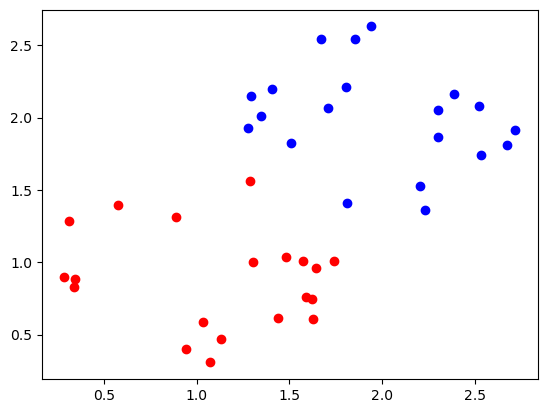

In [3]:
# 生成并查看数据
import matplotlib.pyplot as plt
import random
import pandas as pd

## 定义方法
### 生成一簇数据，总会落在以 center 为中心，半径为 radius 的圆内。
def get_cluster(center, radius, num, label):
    ret = []
    for _ in range(num):
        dx = random.uniform(-1, 1)
        while True:
            dy = random.uniform(-1, 1)
            if pow(dx, 2) + pow(dy, 2) <= 1:
                break
        ret.append({
            "x": center[0] + radius * dx,
            "y": center[1] + radius * dy,
            "label": label
        })
    return pd.DataFrame(ret)

## 生成数据
cluster_0 = get_cluster(center_0, radius_0, num_0, 0)
cluster_1 = get_cluster(center_1, radius_1, num_1, 1)
mixed_data = pd.concat([cluster_0, cluster_1]).sample(frac=1).reset_index(drop=True)
unlabelled_data = mixed_data.drop(columns="label")

## 展示
plt.plot(cluster_0["x"], cluster_0["y"], "or")
plt.plot(cluster_1["x"], cluster_1["y"], "ob")
plt.show()

监督学习（逻辑回归二分类）：

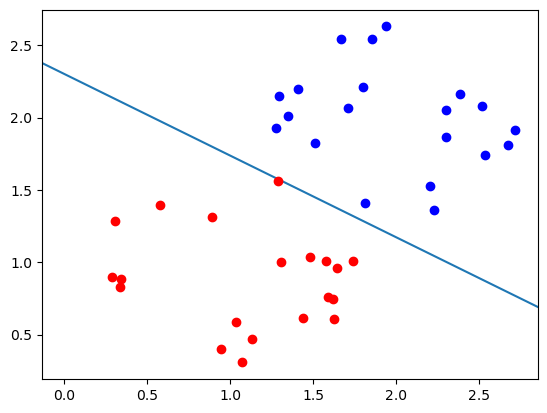

In [4]:
# 监督学习
## 初始化
import torch

## 生成数据
input_data = torch.tensor(unlabelled_data.values, dtype=torch.float32).view(-1, 2)
label_data = torch.tensor(mixed_data.drop(columns=["x", "y"]).values, dtype=torch.float32).view(-1, 1)

## 训练
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1),
    torch.nn.Sigmoid()
)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for _ in range(epoch_num):
    output = model(input_data)
    loss = criterion(output, label_data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
## 绘制图像
w1 = model[0].weight.data[0][0]
w2 = model[0].weight.data[0][1]
bias = model[0].bias.data[0]

k = -w1 / w2
b = -bias / w2

x1 = 0
x2 = 1
y1 = k * x1 + b
y2 = k * x2 + b

plt.axline((x1, y1), (x2, y2))
plt.plot(cluster_0["x"], cluster_0["y"], "or")
plt.plot(cluster_1["x"], cluster_1["y"], "ob")
plt.show()

无监督学习（K-means 聚类）：

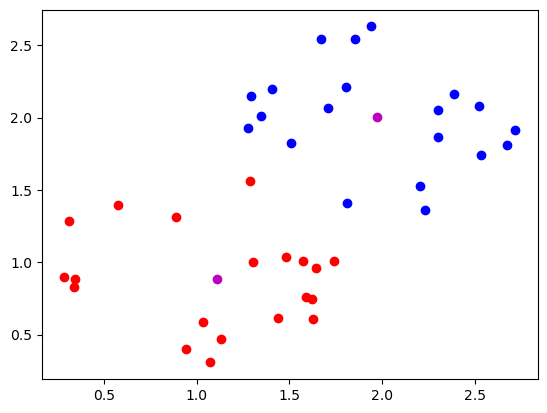

In [5]:
# 无监督学习
## 初始化
import numpy as np

## 取两个随机点作为初始中心点
centroids = unlabelled_data.sample(n=2).values
centroid_0 = centroids[0]
centroid_1 = centroids[1]

i = 0
while True:
    i += 1
    ## 分配每个点到最近的中心点
    dist_0 = np.linalg.norm(unlabelled_data.values - centroid_0, axis=1)    # 二阶范数就是欧氏距离
    dist_1 = np.linalg.norm(unlabelled_data.values - centroid_1, axis=1)    # 范数是啥？
    mask = dist_0 < dist_1
    learnt_cluster_0 = unlabelled_data[mask].reset_index(drop=True)
    learnt_cluster_1 = unlabelled_data[~mask].reset_index(drop=True)

    ## 计算新中心点
    next_centroid_0 = np.average(learnt_cluster_0.values, axis=0)
    next_centroid_1 = np.average(learnt_cluster_1.values, axis=0)

    if i > max_iter or (np.linalg.norm(centroid_0 - next_centroid_0) < tol and np.linalg.norm(centroid_1 - next_centroid_1) < tol):
        break
    centroid_0 = next_centroid_0
    centroid_1 = next_centroid_1

## 绘图
plt.plot(learnt_cluster_0["x"], learnt_cluster_0["y"], "ro")
plt.plot(learnt_cluster_1["x"], learnt_cluster_1["y"], "bo")
plt.plot(centroid_0[0], centroid_0[1], "mo")
plt.plot(centroid_1[0], centroid_1[1], "mo")
plt.show()